In [1]:
import numpy as np
import scipy.spatial.distance as distance
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML


In [2]:
def svgd(x0, dlogp, step_size = 1e-3, iterations = 1000, alpha = 0.9, h = -1):
    #x0 = initial particles (q distributed)
    #dlogp = first derivative of log - probability (function!)
    #step_size = step of gradient descent
    #iterations = number of grad descent iterations
    #alpha = weight of history vs current gradient
    # h = bandwidth of kernel, if < 0 use median trick from paper
    
    x = x0.copy()
    
    epsilon = 1e-6
    hist_grad = 0
    
    
    for l in range(iterations):
        
        dist_mat = distance.squareform(distance.pdist(x)) **2 #use scipy package to calculate pairwise euclidean distance mat
    
        if h < 0 : #as suggested in the paper, calculate bandwith like so
            h = np.sqrt(0.5*np.median(dist_mat) / np.log(x.shape[0]+1))

        kxy = np.exp(-dist_mat / h**2 /2) #rbf kernel formula

        dkxy = -np.matmul(kxy , x) #first part of derivative of kxy
        for i in range(x.shape[1]): #second part of derivative of kxy
            dkxy[:,i] += x[:,i] * np.sum(kxy,axis=1)
        dkxy /= h**2
        
        x_grad = (1/x0.shape[0])*(np.matmul(kxy,dlogp(x)) + dkxy) #formula from Algorithm 1
        
        if l == 0:
            hist_grad = x_grad**2 #here we have no history yet
        else:
            hist_grad = alpha * hist_grad + (1 - alpha) * (x_grad ** 2) #weighted sum of historical and current gradient
            
        adj_grad = x_grad / (np.sqrt(hist_grad) + epsilon) #adagrad formula
        
        x = x + step_size * adj_grad #gradient descent step
    
    return x

In [3]:
class gaussian_mixture_1d:
    def __init__(self,coef,mu,sigma):

        self.mu = mu
        self.sigma = sigma
        self.coef = coef   
        
        if not np.sum(coef) == 1:
            raise ValueError('mixing coefficients must sum to 1')
    
        
    def dlnprob(self,x):
        sum_a = 0
        sum_b = 0
        for i,c in enumerate(self.coef):
            n = c * stats.norm.pdf(x,self.mu[i],self.sigma[i])
            sum_a += n * -(x - self.mu[i])/self.sigma[i]**2
            sum_b += n
        return sum_a / sum_b
    
    def pdf(self,x):
        mixture = 0
        for i,c in enumerate(self.coef):
            mixture += c * stats.norm.pdf(x,self.mu[i],self.sigma[i])
        return mixture

In [4]:
class gaussian_mixture_mv:
    def __init__(self,coef,mu,A):
        
        self.mu = mu
        self.A = A
        self.S = [np.linalg.pinv(Ai) for Ai in A]
        self.coef = coef
        
        if not np.sum(coef) == 1:
            raise ValueError('mixing coefficients must sum to 1')
        
    def dlnprob(self,x):
        sum_a = 0
        sum_b = 0
        for i,c in enumerate(self.coef):
            n = c * stats.multivariate_normal.pdf(x,self.mu[i],self.S[i])
            sum_a += -np.matmul(x - self.mu[i], self.A[i]) * n.reshape(-1,1)
            sum_b += n.reshape(-1,1)
        return sum_a/sum_b
    
    def pdf(self,x):
        mixture = 0
        for i,c in enumerate(self.coef):
            mixture += c * stats.multivariate_normal.pdf(x,self.mu[i],self.S[i])
        return mixture

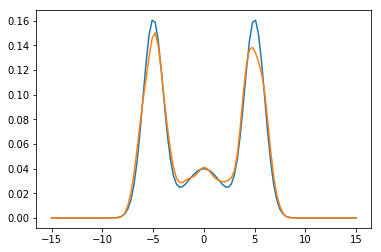

In [5]:
model = gaussian_mixture_1d([2/5,1/5,2/5],[-5,0,5],[1,2,1])

x0 = np.random.normal(-10,size = [100,1])
theta = svgd(x0, model.dlnprob, step_size = 1e-1,iterations = 1000)

density = stats.gaussian_kde(theta.reshape(-1),0.1)
ind = np.linspace(-15,15,101)

plt.plot(ind,model.pdf(ind))
plt.plot(ind,density.evaluate(ind))

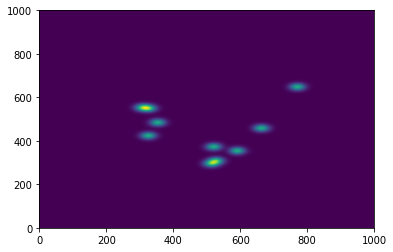

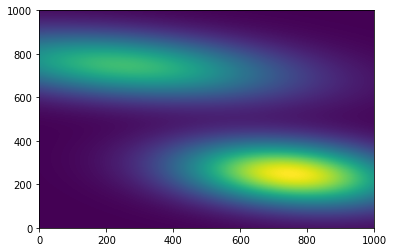

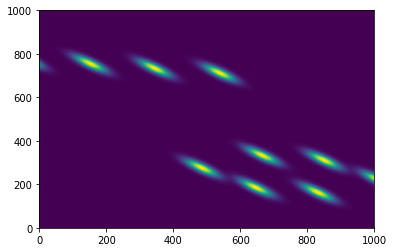

In [10]:
a_0 = np.array([[1,0.1],[0.1,0.2]])
m_0 = np.array([-2.5,2.5])

a_1 = np.array([[1,0.1],[0.1,0.1]])
m_1 = np.array([2.5,-2.5])

model = gaussian_mixture_mv([1/2,1/2],[m_0,m_1],[a_0,a_1])

x0 = np.random.normal(size = [10,2])
theta = svgd(x0,model.dlnprob,step_size=1e-1,iterations = 1000)

density = stats.gaussian_kde(theta.T,0.1)
d0 = stats.gaussian_kde(x0.T,0.1)

x, y = np.mgrid[-5:5:.01, -5:5:.01]
pos = np.dstack((x, y))

model_density = density.evaluate((x.flatten(),y.flatten()))

plt.figure()
plt.pcolormesh(d0.evaluate((x.flatten(),y.flatten())).reshape(1000,1000))
plt.figure()
plt.pcolormesh(model.pdf(np.dstack((x.flatten(),y.flatten()))).reshape(1000,1000))
plt.figure()
plt.pcolormesh(model_density.reshape(1000,1000))



In [7]:
model = gaussian_mixture_1d([2/3,1/3],[-2,2],[1,1])

ind = np.linspace(-15,15,101)

test = model.pdf(ind).copy()

x0 = np.random.normal(-10,size = [100,1])
density0 = stats.gaussian_kde(x0.reshape(-1),0.4)
dens = []
for i in range(20):
    density = stats.gaussian_kde(x0.reshape(-1),0.3)
    dens.append(density.evaluate(ind))
    x = svgd(x0,model.dlnprob,step_size=1e-1,iterations = 50)
    x0 = x



fig, ax = plt.subplots(1,2)

line0, = ax[0].plot(ind, test)
line0, = ax[0].plot(ind, density0.evaluate(ind))

def animate(i):
    line0.set_ydata(dens[i])
    return line0,

ani = animation.FuncAnimation(fig, animate, interval=1000, save_count = 10)

#writer = animation.ImageMagickWriter(fps=15)
#ani.save("movie.gif", writer=writer)

aa = HTML(ani.to_jshtml())
#to only show the video and not also the endstate
fig.clear()
aa

In [92]:
#a_0 = np.array([[0.01,0.5],[0.5,0.01]])
a_0 = np.linalg.pinv([[2,0.5],[0.5,2]])
m_0 = np.array([-4,1])

#a_1 = np.array([[0.01,0.5],[0.5,0.01]])
a_1 = np.linalg.pinv([[2,0.5],[0.5,2]])
m_1 = np.array([1,-4])

As = [a_0,a_1] #list of covariance matrices
ms = [m_0,m_1] #list of mean vectors
coef = [1/2,1/2] #mixing coefficient

it = 50 #how many repetitions of the algorithm to use for the animation

xa = ya = -20 #lower bound of the final plot and grid to evaluate the densities on
xb = yb = 20 #upper bound of the final plot and grid to evaluate the densities on
#x and y don't have to be equal !


theta0 = np.random.normal([-10,10],size = [300,2]) #initial distribution

model = gaussian_mixture_mv(coef,ms,As)

thetas = [theta0]
for i in range(it):
    theta = svgd(theta0,model.dlnprob,step_size=1e-1,iterations = 10)
    thetas.append(theta)
    
    theta0 = theta

In [93]:
idx = np.arange(xa,xb,0.01)
idy = np.arange(ya,yb,0.01)
x, y = np.meshgrid(idx, idy)
pos = np.dstack((x.flatten(),y.flatten()))
target_dens = model.pdf(pos).reshape(len(idx),len(idy))
#model_dens = [stats.gaussian_kde(thetas[i].T,0.7)
#              .evaluate((x.flatten(),y.flatten())).reshape(len(idx),len(idy)) 
#              for i in range(it)]
model_dens = [np.zeros((len(idx),len(idy))) for i in range(it)]

In [94]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
ln, = ax[0].plot([], [], 'ro')
ax[0].contour(idx,idy,target_dens.T)
ax[0].set_xlim([xa,xb])
ax[0].set_ylim([ya,yb])
cd = ax[1].contour(idx,idy,model_dens[0])
ax[1].set_xlim([xa,xb])
ax[1].set_ylim([ya,yb])
def update(i):
    ln.set_data(thetas[i][:,1], thetas[i][:,0])
    global cd
    z = model_dens[i]
    
    for c in cd.collections:
        c.remove()

    cd = plt.contour(idx,idy,z)
    return ln,cd

ani = animation.FuncAnimation(fig, update,interval=500, save_count = it)
aa = HTML(ani.to_jshtml())
#to only show the video and not also the endstate
fig.clear()

aa


C:\Users\T480\Anaconda3\lib\site-packages\matplotlib\contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


Traceback (most recent call last):
  File "C:\Users\T480\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 388, in process
    proxy(*args, **kwargs)
  File "C:\Users\T480\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 228, in __call__
    return mtd(*args, **kwargs)
  File "C:\Users\T480\Anaconda3\lib\site-packages\matplotlib\animation.py", line 1081, in _start
    self._init_draw()
  File "C:\Users\T480\Anaconda3\lib\site-packages\matplotlib\animation.py", line 1792, in _init_draw
    self._draw_frame(next(self.new_frame_seq()))
  File "C:\Users\T480\Anaconda3\lib\site-packages\matplotlib\animation.py", line 1814, in _draw_frame
    self._drawn_artists = self._func(framedata, *self._args)
  File "<ipython-input-94-224a8c2b6d9b>", line 15, in update
    c.remove()
  File "C:\Users\T480\Anaconda3\lib\site-packages\matplotlib\artist.py", line 151, in remove
    self._remove_method(self)
  File "C:\Users\T480\Anaconda3\lib\site-packages\matplotlib\axes\_bas

(-20, 20)

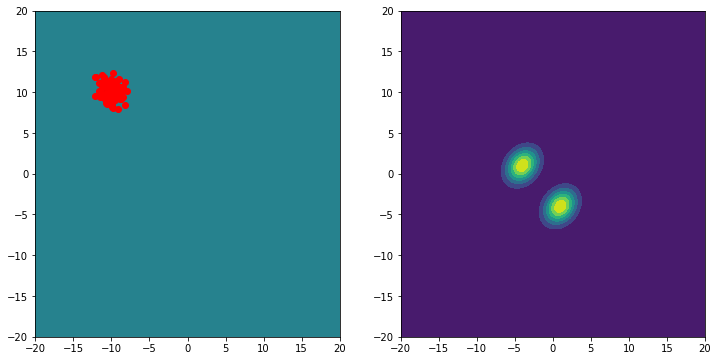

In [91]:
fig,ax = plt.subplots(1,2,figsize=(12,6))
ax[0].contourf(idx,idy,model_dens[0])
ax[0].plot(thetas[0][:,0],thetas[0][:,1],'ro')
ax[0].set_xlim([xa,xb])
ax[0].set_ylim([ya,yb])
ax[1].contourf(idx,idy,target_dens)
ax[1].set_xlim([xa,xb])
ax[1].set_ylim([ya,yb])